# Applications of Gradient Boosting

This notebook requires `hep_ml`. If you're not using cloud, use 
```
pip install hep_ml
```

## Reweighting of distributions with Boosted Decision Trees

Initially you have two distrubtions sample_original, sample_target. 

You need to reweight distribution, that is assign new weights to original distribution so that there is no difference between sample_original (with new weights) and sample_target.

 - reweighting in physics (correction of Monte Carlo simulation)
 - reweighting in surveying (correction for non-response bias)
 
More details about reweighting can be found [in these slides](https://indico.cern.ch/event/397113/session/16/contribution/202/attachments/1213955/1771752/ACAT2016-reweighting.pdf)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import root_numpy
import pandas

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

## Load the data
Dataset is anonymized, so no names of features.
In HEP terms, original distibution is simulation, target distribution is Real Data


In [2]:
original = pandas.DataFrame(root_numpy.root2array('./data/4-original.root'))
target   = pandas.DataFrame(root_numpy.root2array('./data/4-target.root'))

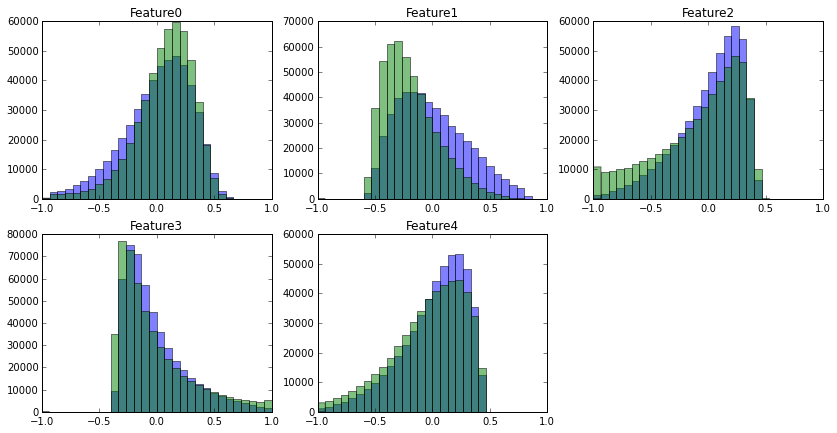

In [3]:
plt.figure(figsize=[14, 7])
for i, column in enumerate(original.columns, start=1):
    plt.subplot(2, 3, i)
    plt.title(column)
    plt.hist(original[column], range=[-1, 1], bins=30, alpha=0.5)
    plt.hist(target[column],   range=[-1, 1], bins=30, alpha=0.5)

## Comparison of multidimensional distributions

When you need to say, whether two samples have same distribution, you have options:

- simple and wrong: look at 1-dimensional distributions
- good and complex: find out, whether classification model is able to find difference between two distributions. <br />
  As usual, we train on part of the data and then check quality on a holdout. Let's see:

In [4]:
train_original, test_original = train_test_split(original, train_size=0.4, random_state=42)
train_target,   test_target   = train_test_split(target, train_size=0.4, random_state=42)

In [5]:
# using the default parameters, 
# BUT in practice you should take parameters of classification model used in your analysis
clf = GradientBoostingClassifier()
trainX = numpy.vstack([train_original, train_target])
trainY = [0] * len(train_original) + [1] * len(train_target)
clf.fit(trainX, trainY)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [6]:
testX = numpy.vstack([test_original, test_target])
testY = [0] * len(test_original) + [1] * len(test_target)
test_proba = clf.predict_proba(testX)
train_proba = clf.predict_proba(trainX)

## Checking the discrimination using ROC

pay attention - we used train/test splitting. We see that there is large difference between distributions, and classification model easily found it:

ROC AUC 0.745808225922


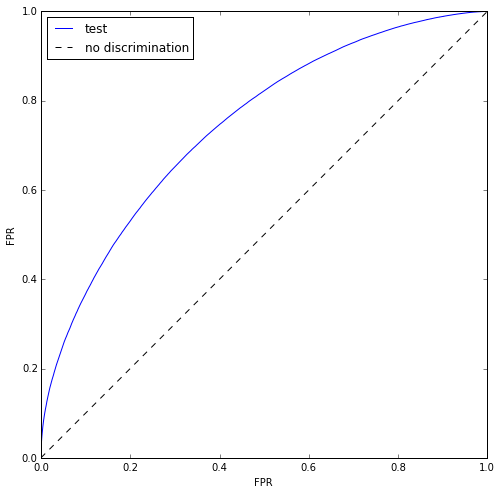

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(testY,  test_proba[:, 1])[:2],  label='test')
plt.plot([0, 1], [0, 1], 'k--', label='no discrimination')
plt.xlabel('FPR'), plt.ylabel('FPR')
plt.legend(loc='best')

print 'ROC AUC', roc_auc_score(testY,  test_proba[:, 1])

## Putting uniformity as a restriction during boosting

In physics, frequently we want classifier not to rely on some variables: mass, lifetime, Dalitz variables.

In certain situations we don't want to use gender and race. 
I.e. if you're hiring programmers, you have information about good programmers in your company and you're scanning for similar people among facebook accounts. Of course, classifier will heavily rely on gender. If you simply exclude the gender from information, this is not of much help, since classifier can easily reconstruct that from texts and other information on facebook.

Example with mass in rare decays:
- mass of mother particle is main feature. Events outside certain region are background
- after thresholding on classifier if there is a peak in the mass region, we claim a discovery of decay
- false peaks (=false discovery) appear if background with some mass passes selection with higher probability.
- things are even worse if we train on sidebands (mass becomes strong feature)
- mathematically, we expect to have constant FPR along mass
- we should prevent ML from using mass or reconstructing mass
- we can do it by modifyting boosting procedure

More details can be found in papers:
 - http://arxiv.org/pdf/1305.7248.pdf
 - http://arxiv.org/pdf/1410.4140.pdf

In [8]:
# the code below is just for demonstration of idea, 
# you don't need uniform boosting for kaggle.
from hep_ml.gradientboosting import UGradientBoostingClassifier, BinFlatnessLossFunction
# we say that loss function should contain a term to penalize for non-uniformity in mass
loss = BinFlatnessLossFunction(uniform_features=['mass'], uniform_label=0)
# we also put all features for the exception of mass to use in training
clf = UGradientBoostingClassifier(loss=loss, train_features=['pt', 'phi', '...and all other features']) 

## Homework 4

First two exercises are due to Friday.
Exercises about reweighting (#3, #4) are due to Monday.


**Exercise #1.** Tune GBDT as described in the class on Higgs dataset. You should overcome RandomForest! Submit best result on kaggle.

**Exercise #2.** Check the correlation between RandomForest and GBDT (using scatter plot). Find an optimal linear combination of GBDT and RandomForest using Logistic regression.

**Exercise #3.** Reweight distribution using bins. Find optimal feature for reweighting and optimal number of bins. Use code given below. Optionally, you can try n-dimensional reweighting with bins (use `numpy.histogram2d` or `numpy.histogramdd`)

**Exercise #4.** Reweight distribution using BDT. Tune max_depth, n_estimators and other parameters to achieve good reweighting rule.
Use code given below


## Function for minimal testing of reweighing

In [9]:
# we prepared a special function for testing reweighting
# it plots 
# pay attention - you should use train_original, train_target to 
def check_discrimination(new_test_original_weights):
    new_test_original_weights = numpy.array(new_test_original_weights)
    new_test_original_weights /= 1. * numpy.mean(new_test_original_weights)
    plt.figure(figsize=[14, 7])
    for i, column in enumerate(original.columns, start=1):
        plt.subplot(2, 3, i)
        plt.title(column)
        plt.hist(test_original[column], range=[-1, 1], bins=30, alpha=0.5, normed=True, weights=new_test_original_weights)
        plt.hist(test_target[column],   range=[-1, 1], bins=30, alpha=0.5, normed=True)
    plt.show()

    X = numpy.vstack([test_original, test_target])
    y = [0] * len(test_original) + [1] * len(test_target)
    sample_weights = numpy.concatenate((new_test_original_weights, [1] * len(test_target)))
    
    trainX, testX, trainY, testY, trainW, testW = train_test_split(X, y, sample_weights, train_size=0.45, random_state=42)
    
    # using only 30 trees for speed 
    clf = GradientBoostingClassifier(n_estimators=30, random_state=42)
    clf.fit(trainX, trainY, sample_weight=trainW)
    test_proba = clf.predict_proba(testX)
    
    plt.figure(figsize=[8, 8])
    plt.plot(*roc_curve(testY,  test_proba[:, 1], sample_weight=testW)[:2], label='test')
    print 'ROC AUC', roc_auc_score(testY,  test_proba[:, 1], sample_weight=testW)
    plt.plot([0, 1], [0, 1], 'k--', label='no discrimination')
    plt.xlabel('FPR'), plt.ylabel('FPR')
    plt.legend(loc='best')
    plt.plot()

## Reweighting with bins

we train a reweighitng rule on part of a data and then check it with other part.

In [10]:
feature = 'Feature0'
origin_counts, bin_limits = numpy.histogram(train_original[feature], bins=10, range=[-1, 1])
target_counts, _ = numpy.histogram(train_target[feature], bins=bin_limits)
# computing ratio in each bin
counts_ratio = target_counts * 1. /  origin_counts
# computing bin index for each sample
bin_indices = numpy.searchsorted(bin_limits[1:], test_original[feature])
# taking new weights from original weights
new_test_original_weights = counts_ratio[bin_indices]

In [11]:
# for comparison: no reweighting
# check_discrimination(numpy.ones(len(test_original)))

In [12]:
# check_discrimination(new_test_original_weights)

## Reweighting with BDT

In [13]:
from hep_ml.reweight import GBReweighter
reweighter = GBReweighter(n_estimators=10, max_depth=2, learning_rate=0.4)
reweighter.fit(train_original, train_target)
new_bdt_test_original_weights = reweighter.predict_weights(test_original)

In [14]:
# check_discrimination(new_bdt_test_original_weights)